# The Simplest NN
This code builds a 2-layer NN and applies it to recogition of handwritten digits.
Tested on Deep Learning AMI Amazon Linux - 3.3_Oct2017 (ami-999844e0),
Instance type m4.xlarge

In [4]:
import tensorflow as tf
import numpy as np
import os

Here we load 'mnist' dataset of handwritten images (https://keras.io/datasets/) with help of an already provided function *load_dataset*. Be sure that the file *preprocessed_mnist.py* is in your working directory.

Now we also want to know the shapes of the original train/test-data and visualize some symbols from the train data. We will want to classify each handwritten symbol as a digit: 0,1,...,9.

Using TensorFlow backend.


10469376/11490434 [==========================>...] - ETA: 0s(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)


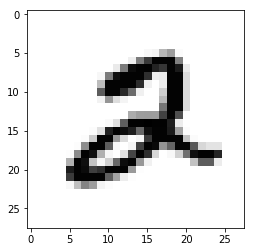

In [5]:
# os.chdir("D:\\Downloads\\")
from preprocessed_mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[5], cmap="Greys")

We want the image data to be in a flat format, so let's reload the reshaped version of the dataset and print new shapes.

In [6]:
X_train_flat, y_train, X_val_flat, y_val, X_test_flat, y_test = load_dataset(flatten=True)
print("X and y train shape:", X_train_flat.shape, y_train.shape)
print("X and y test shape:", X_test_flat.shape, y_test.shape)

X and y train shape: (50000, 784) (50000,)
X and y test shape: (10000, 784) (10000,)


We will also want to convert categorical labels of 10 classes to binary format.

In [7]:
s = tf.Session()

# Categorical labels to binaries
y_train_oh = s.run(tf.one_hot(y_train, 10))
y_test_oh  = s.run(tf.one_hot(y_test, 10))
y_val_oh   = s.run(tf.one_hot(y_val, 10))

# Logistic regression
Here we will implement our simple NN with 1 hidden layer having 50 neurons.

First let's create variables for weights and biases and placeholders for input data:

In [8]:
# Model parameters - weights and bias
nhid   = 50
nclass = len(np.unique(y_train))
weights_hid = tf.Variable(tf.random_normal([X_train_flat.shape[1], nhid], stddev=0.35),
                      name="weights_h") 

b_hid = tf.Variable(tf.zeros([nhid]), dtype='float32', name="biases_h")

weights_out = tf.Variable(tf.random_normal([nhid, nclass], stddev=0.35),
                      name="weights") 

b_out = tf.Variable(tf.zeros([nclass]), dtype='float32', name="biases")

# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None,X_train_flat.shape[1]))
input_y = tf.placeholder('float32', shape=(None, nclass))
input_X, input_y, weights_hid, weights_out, b_hid, b_out

(<tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?, 10) dtype=float32>,
 <tf.Variable 'weights_h:0' shape=(784, 50) dtype=float32_ref>,
 <tf.Variable 'weights:0' shape=(50, 10) dtype=float32_ref>,
 <tf.Variable 'biases_h:0' shape=(50,) dtype=float32_ref>,
 <tf.Variable 'biases:0' shape=(10,) dtype=float32_ref>)

Now implement the model itself. The outpit layer uses softmax non-linearity, hidden layer - *relu* activation function.

**Loss** will be a softmax cross entropy between log probabilities and labels.  
**Optimization method** - gradient decent.  
**Accuracy** is just a proportion of correct predictions.

In [9]:
# model
#predicted_y =  tf.nn.softmax(tf.matmul(input_X, weights)+b)
predicted_y_hid =  tf.nn.relu(tf.matmul(input_X, weights_hid)+b_hid)
predicted_y     =  tf.matmul(predicted_y_hid, weights_out)+b_out

# Loss. Should be a scalar number - average loss over all the objects
#loss = tf.reduce_mean(-tf.reduce_sum(tf.log(predicted_y+1e-07)*input_y, reduction_indices=[1]))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=predicted_y))

# See above for an example. tf.train.*Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(
    loss, var_list=(weights_hid, b_hid, weights_out, b_out))

# compute accuracy
correct_prediction = tf.equal(tf.argmax(predicted_y,1), tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We will make 400 learning iterations and also show loss, auc on train and test data for each iteration.

In [10]:
from sklearn.metrics import roc_auc_score

trainloss = list()
testloss  = list()
acctrain  = list()
acctest   = list()
s.run(tf.global_variables_initializer())


# run optimizing iterations
for i in range(400):
    #batchX, batchY = s.run(tf.train.batch([X_train_flat, y_train_oh],100,enqueue_many=True, capacity=1))
    s.run(optimizer, {input_X: X_train_flat, input_y: y_train_oh})
    #s.run(optimizer, {input_X: batchX, input_y: batchY})
    loss_i = s.run(loss, {input_X: X_train_flat, input_y: y_train_oh})
    trainloss.append(loss_i)
    loss_i = s.run(loss, {input_X: X_test_flat, input_y: y_test_oh})
    testloss.append(loss_i)
    acctrain.append(s.run(accuracy, feed_dict={input_X:X_train_flat, input_y: y_train_oh}))
    acctest.append(s.run(accuracy, feed_dict={input_X:X_test_flat, input_y: y_test_oh}))
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train_oh, s.run(predicted_y, {input_X:X_train_flat})))
    print("test auc:", roc_auc_score(y_test_oh, s.run(predicted_y, {input_X:X_test_flat})))

loss at iter 0:6.4002
train auc: 0.668213788996
test auc: 0.673123772612
loss at iter 1:4.3656
train auc: 0.720813859766
test auc: 0.729215355947
loss at iter 2:2.0133
train auc: 0.763423154025
test auc: 0.770695971169
loss at iter 3:1.6676
train auc: 0.792972168506
test auc: 0.800889618971
loss at iter 4:1.5208
train auc: 0.811522323523
test auc: 0.819310601054
loss at iter 5:1.4097
train auc: 0.826611364539
test auc: 0.834239930252
loss at iter 6:1.3180
train auc: 0.839471938465
test auc: 0.846847623978
loss at iter 7:1.2404
train auc: 0.85058253059
test auc: 0.8576339799
loss at iter 8:1.1729
train auc: 0.860292215288
test auc: 0.867071367751
loss at iter 9:1.1140
train auc: 0.868812701412
test auc: 0.875288257712
loss at iter 10:1.0618
train auc: 0.876323655252
test auc: 0.882542302366
loss at iter 11:1.0158
train auc: 0.882910931532
test auc: 0.888871278322
loss at iter 12:0.9748
train auc: 0.888727771482
test auc: 0.89442004594
loss at iter 13:0.9383
train auc: 0.893878525634
tes

loss at iter 111:0.3803
train auc: 0.959559930083
test auc: 0.960906395956
loss at iter 112:0.3792
train auc: 0.959670389448
test auc: 0.96100583861
loss at iter 113:0.3780
train auc: 0.959779909056
test auc: 0.961105510327
loss at iter 114:0.3769
train auc: 0.959887122646
test auc: 0.961201823319
loss at iter 115:0.3758
train auc: 0.959994021401
test auc: 0.961297574967
loss at iter 116:0.3747
train auc: 0.960099316462
test auc: 0.961394584493
loss at iter 117:0.3736
train auc: 0.960203557327
test auc: 0.961486832685
loss at iter 118:0.3726
train auc: 0.960306589796
test auc: 0.961582302239
loss at iter 119:0.3715
train auc: 0.960407814363
test auc: 0.961674111554
loss at iter 120:0.3705
train auc: 0.960508028061
test auc: 0.961762291933
loss at iter 121:0.3694
train auc: 0.960607403026
test auc: 0.961852882511
loss at iter 122:0.3684
train auc: 0.960705640648
test auc: 0.961940751365
loss at iter 123:0.3674
train auc: 0.960801858275
test auc: 0.962028291813
loss at iter 124:0.3664
tr

loss at iter 221:0.3022
train auc: 0.967282385966
test auc: 0.967753364408
loss at iter 222:0.3017
train auc: 0.967328776798
test auc: 0.96779211986
loss at iter 223:0.3013
train auc: 0.967374382292
test auc: 0.967831211292
loss at iter 224:0.3008
train auc: 0.967420035983
test auc: 0.967870803496
loss at iter 225:0.3004
train auc: 0.967465184037
test auc: 0.967909535415
loss at iter 226:0.2999
train auc: 0.967509879298
test auc: 0.967947529129
loss at iter 227:0.2995
train auc: 0.967554505627
test auc: 0.967984938852
loss at iter 228:0.2991
train auc: 0.967598725369
test auc: 0.968022577414
loss at iter 229:0.2987
train auc: 0.967643371566
test auc: 0.968062529994
loss at iter 230:0.2982
train auc: 0.967687408025
test auc: 0.968099708105
loss at iter 231:0.2978
train auc: 0.967731370246
test auc: 0.968135883735
loss at iter 232:0.2974
train auc: 0.96777512619
test auc: 0.968172536885
loss at iter 233:0.2970
train auc: 0.967818651937
test auc: 0.968209665494
loss at iter 234:0.2966
tra

loss at iter 331:0.2646
train auc: 0.971286766755
test auc: 0.971081675297
loss at iter 332:0.2643
train auc: 0.97131556912
test auc: 0.971105763987
loss at iter 333:0.2641
train auc: 0.971344227611
test auc: 0.971128692378
loss at iter 334:0.2638
train auc: 0.971373085856
test auc: 0.971153351929
loss at iter 335:0.2636
train auc: 0.97140197639
test auc: 0.971177076814
loss at iter 336:0.2633
train auc: 0.971431039676
test auc: 0.971201037537
loss at iter 337:0.2631
train auc: 0.971459711891
test auc: 0.971223050839
loss at iter 338:0.2628
train auc: 0.971488368575
test auc: 0.971246478128
loss at iter 339:0.2625
train auc: 0.971516862957
test auc: 0.971271211799
loss at iter 340:0.2623
train auc: 0.971545123574
test auc: 0.971295069246
loss at iter 341:0.2620
train auc: 0.971573592971
test auc: 0.97131858144
loss at iter 342:0.2618
train auc: 0.97160191483
test auc: 0.971343108939
loss at iter 343:0.2615
train auc: 0.971629762094
test auc: 0.971367459105
loss at iter 344:0.2613
train

Let's see the plots of loss and accuracy on train and test data for each iteration.

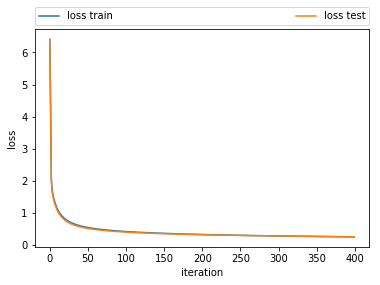

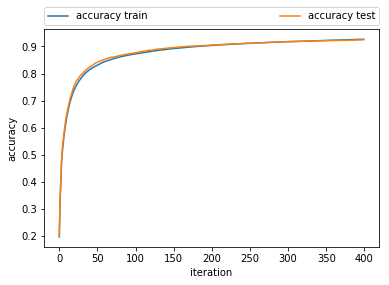

In [11]:
plt.plot(trainloss, label = "loss train")
plt.plot(testloss, label="loss test")
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

plt.plot(acctrain, label = "accuracy train")
plt.plot(acctest, label  = "accuracy test")
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


Here we will print the accuracy (proportion of correct predictions) reached after 400 learning steps.

In [12]:
correct_prediction = tf.equal(tf.argmax(predicted_y,1), tf.argmax(input_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy on train data:", s.run(accuracy, feed_dict={input_X:X_train_flat, input_y: y_train_oh}))
print("Accuracy on val data:"  , s.run(accuracy, feed_dict={input_X:X_val_flat, input_y: y_val_oh}))
print("Accuracy on test data:" , s.run(accuracy, feed_dict={input_X:X_test_flat, input_y: y_test_oh}))

Accuracy on train data: 0.92684
Accuracy on val data: 0.9254
Accuracy on test data: 0.9247
